Uncomment the following lines if running on Google Colaboratory. This will install versions of PyTorch and CuPy that work with our package, and then download the package files from the GitHub repo.

Restart the runtime when prompted to in the output of the cell.

In [1]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cupy-cuda110
# !git clone https://github.com/BouazzaSE/NeuralXVA
# !mv NeuralXVA/* ./
# !rm -R NeuralXVA

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from learning.im_estimator import IMEstimatorPortfolio
from learning.misc import predict, predict_only_stats
from simulation.diffusion_engine import DiffusionEngine
import time
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = '100'

In [3]:
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumbaPerformanceWarning)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

## Simulation parameters

* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in \[1\]);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in \[1\]);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of \[1\]:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

**\[1\]** Abbas-Turki, L., S. Crépey, and B. Saadeddine (2022). Hierarchical simulation for learning with defaults. Pre-print available on https://perso.lpsm.paris/~crepey/papers/LEARNING_FROM_DEFAULTS.pdf.

In [6]:
num_coarse_steps = 100
dT = 0.1
num_fine_per_coarse = 25
dt = 0.004
num_paths = 2**19 # preferable to go for at least around 2**22 for better results
num_inner_paths = 1
num_defs_per_path = 1
num_rates = 10
num_spreads = 2
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.4, 0.03, num_rates)
rates_params['b'] = np.random.normal(0.03, 0.001, num_rates)
rates_params['sigma'] = np.abs(np.random.normal(0.0025, 0.00025, num_rates))
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.25, 0.025, num_rates-1))
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameters
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.5, 0.03, num_spreads)
spreads_params['b'] = np.random.normal(0.01, 0.001, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.0075, 0.00075, num_spreads))
initial_values[2*num_rates-1:] = 0.01

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0
vanilla_specs = np.empty(num_vanillas,
                         dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])

num_irs = 100
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 0.2  # Reset frequency
irs_specs['notional'] = 10000. * \
    ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5)))
     * np.random.choice(range(1, 11), num_irs))  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs))  # Swap rate, not needed, swaps are priced at par anyway
irs_specs['num_resets'] = np.random.randint(6, 51, num_irs, np.int32)  # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates-1, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs,
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

Next, we select the GPU. Should be `cuda:0` if there is only one GPU available. This is where both the simulation and the training/inference are going to be performed.

In [7]:
device = torch.device('cuda:0')

We then instantiate the diffusion engine and the IM estimator.

In [8]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device=device.index,
                                   no_nested_im=True, no_nested_cva=True)

# selector for previous swap resets, need the states at those dates because of how the small non-Markovianity in the swap prices
num_steps_per_reset = int((irs_specs['reset_freq'][0]+dt)/dT)
prev_reset_arr = (np.arange(num_coarse_steps+1)-1)//num_steps_per_reset*num_steps_per_reset

# IM learner
alpha = torch.tensor(0.025, dtype=torch.float32, device=device) # corresponds to confidence level 1-alpha 
                                                                # for the VaR, which is 97.5% in this example
im_estimator = IMEstimatorPortfolio(0, 'pay', alpha, 1, prev_reset_arr, True, False, False, 
                                                   diffusion_engine, device, 3, 6*num_rates, 
                                                   (num_defs_per_path*num_paths)//32, 16, 0.01, 0, 
                                                   reset_weights=False, linear=False, best_sol=True)

Successfully compiled all kernels.


## Training

Creating CUDA events in order to do some timings later:

In [9]:
with torch.cuda.device(device):
    _evt_start = torch.cuda.Event(enable_timing=True)
    _evt_stop = torch.cuda.Event(enable_timing=True)

We launch a first set of simulations in order to have paths on which to train on. This will simulate the risk factors and do all the pricings at the coarse time-steps.

In [10]:
_evt_start.record()
diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Everything done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 42483.228 ms
Everything done in 45157.672 ms


We create a generator for the features and tell it to keep the data in CUDA memory and implicitly copy when assigning to Numpy arrays, and then we launch the training for the default indicators version.

In [11]:
print('Training...', end='')
_evt_start.record()
im_estimator.train(labels_as_cuda_tensors=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Training...done in 204.9 secs


At this point, a Neural Network estimator has been trained and the weights for any time-step `i` have been stored in the `.saved_states[i]`, *ie* if one wants to look at the parameters at time-step 20:

In [12]:
im_estimator.saved_states[20]

(True,
 (OrderedDict([('h.0.W',
                tensor([[-0.4888,  1.3725, -0.7091,  ..., -0.4046, -0.1107, -0.4132],
                        [-0.4630, -0.4389, -0.5513,  ...,  1.1471, -0.5308,  0.3496],
                        [-1.0356, -1.9978,  0.6267,  ...,  0.0585,  1.8700,  0.3822],
                        ...,
                        [ 0.3627,  0.3261, -0.7545,  ...,  0.8386,  0.0722, -1.1304],
                        [ 0.8868,  1.4725,  1.7477,  ..., -1.0291, -1.3300,  1.9255],
                        [ 1.2166, -2.0393, -0.4056,  ..., -1.8730, -0.8137,  0.2943]],
                       device='cuda:0')),
               ('h.0.b',
                tensor([[ -2.1442,  -2.9001,  -3.4251,  -9.9187,  -1.6582,   2.6159,  -0.3097,
                          -8.2062,   2.8332,  -7.6555,  -1.6873,  -1.2114,  -7.4928,  -3.4604,
                          -2.3024,  -6.0964,  -4.6285,  -4.6055,  -4.9549,  -3.7753, -10.1262,
                          -8.0562,  -4.8172,  -2.6844,   0.0473,  -5.2

Notice the first component is `True`. When it instead is `False`, it simply means that no learning has been done, because either it was the first time-step (simple unconditional average) or a time-step at which the labels have numerically zero variance (in which case the conditional expectation is simply the unconditional average).

## Inference

Now we would like to output IM values from our trained learner. We first launch a new set of paths. This time, we tell the diffusion engine to run a Nested Monte Carlo simulation at time-steps 30, 60, and 90 in order to get a NMC estimator of the IM at those time-steps, which will be used as a benchmark against which we will compare the learners below.

We will first recreate our DiffusionEngine in order to reduce the number of outer paths to allow for enough inner paths. We need less outer paths than previously because now we're done learning. We also correspondingly update our IMEstimator because the sample size changed.

In [13]:
import gc

old_num_paths = num_paths
num_paths = 2**14 # 2**15
num_inner_paths = 512 # 1024
num_defs_per_path = 1

diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device=device.index,
                                   no_nested_im=False, no_nested_cva=True)

im_estimator.diffusion_engine = diffusion_engine
im_estimator._estimator.num_samples = num_defs_per_path*num_paths
im_estimator._estimator.batch_size = im_estimator.batch_size = (num_defs_per_path*num_paths)//32 # (num_defs_per_path*num_paths)//32

gc.collect()

Successfully compiled all kernels.


125

In [14]:
_evt_start.record()
for _ in range((old_num_paths+num_paths-1)//num_paths):
    diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

cuda_diffuse_and_price elapsed time: 1654.931 ms
cuda_diffuse_and_price elapsed time: 1648.927 ms
cuda_diffuse_and_price elapsed time: 1683.273 ms
cuda_diffuse_and_price elapsed time: 1700.345 ms
cuda_diffuse_and_price elapsed time: 1699.833 ms
cuda_diffuse_and_price elapsed time: 1715.563 ms
cuda_diffuse_and_price elapsed time: 1737.263 ms
cuda_diffuse_and_price elapsed time: 1733.806 ms
cuda_diffuse_and_price elapsed time: 1741.39 ms
cuda_diffuse_and_price elapsed time: 1735.407 ms
cuda_diffuse_and_price elapsed time: 1732.788 ms
cuda_diffuse_and_price elapsed time: 1734.14 ms
cuda_diffuse_and_price elapsed time: 1735.608 ms
cuda_diffuse_and_price elapsed time: 1733.186 ms
cuda_diffuse_and_price elapsed time: 1800.936 ms
cuda_diffuse_and_price elapsed time: 1804.671 ms
cuda_diffuse_and_price elapsed time: 1804.106 ms
cuda_diffuse_and_price elapsed time: 1786.416 ms
cuda_diffuse_and_price elapsed time: 1749.691 ms
cuda_diffuse_and_price elapsed time: 1757.008 ms
cuda_diffuse_and_price

In [15]:
# uncomment if you want to compute a Nested MC estimator

# nested_timesteps = [30, 60, 90]
# diffusion_engine.generate_batch(fused=True, set_irs_at_par=True, nested_im_at=nested_timesteps, alpha=alpha, im_window=1)

In order to perform inference, one normally needs a *predictor* (via `.predict`) and then iterate over the time-steps and call it as needed to generate the predictions. Note that the predictor will also need a features generator. Thankfully, a helper function `predict` from `learning.misc` is provided and makes life much easier.

In [16]:
print('Performing inference...', end='')
_evt_start.record()
predicted_im_out = predict(im_estimator, num_coarse_steps, 1, num_paths)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Performing inference...done in 1.46 secs


In [17]:
predicted_im_out

array([[1.5229010e+03, 1.5229010e+03, 1.5229010e+03, ..., 1.5229010e+03,
        1.5229010e+03, 1.5229010e+03],
       [1.5614735e+03, 1.9515375e+03, 1.5836858e+03, ..., 1.5505847e+03,
        1.6093274e+03, 1.6404452e+03],
       [1.5722842e+03, 1.8400312e+03, 1.4518561e+03, ..., 1.5722842e+03,
        1.7614747e+03, 1.5722842e+03],
       ...,
       [5.1470852e-04, 5.3888693e-04, 4.8899307e-04, ..., 4.8566880e-04,
        4.8383159e-04, 4.8942608e-04],
       [5.4852728e-04, 6.2293553e-04, 4.9058173e-04, ..., 4.8308386e-04,
        5.0407613e-04, 4.8160966e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

Now we plot a few statistics of the learned IM along the time axis (unconditional mean & a few percentiles) and also plot the same statistics for our NMC estimator.

If we want only statistics and not individual realizations, then the following is enough and launching `predict` as we did previously is not necessary. This will not be faster but it will use less memory, as storing all realizations for all time steps is not necessary and only statistics are stored at each time step.

In [18]:
stats = ('mean', ('quantile', 0.99), ('quantile', 0.975), ('quantile', 0.025), ('quantile', 0.01))

predicted_im_stats = predict_only_stats(im_estimator, stats, num_coarse_steps, recompute_at_zero=True)

# uncomment the following lines if you're including the Nested MC estimator
# nested_im_stats = {
#     'mean': diffusion_engine.nested_im_by_cpty[nested_timesteps, 0].mean(axis=1),
#     ('quantile', 0.975): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 97.5, axis=1),
#     ('quantile', 0.025): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 2.5, axis=1),
#     ('quantile', 0.99): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 99, axis=1),
#     ('quantile', 0.01): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 1, axis=1)
# }

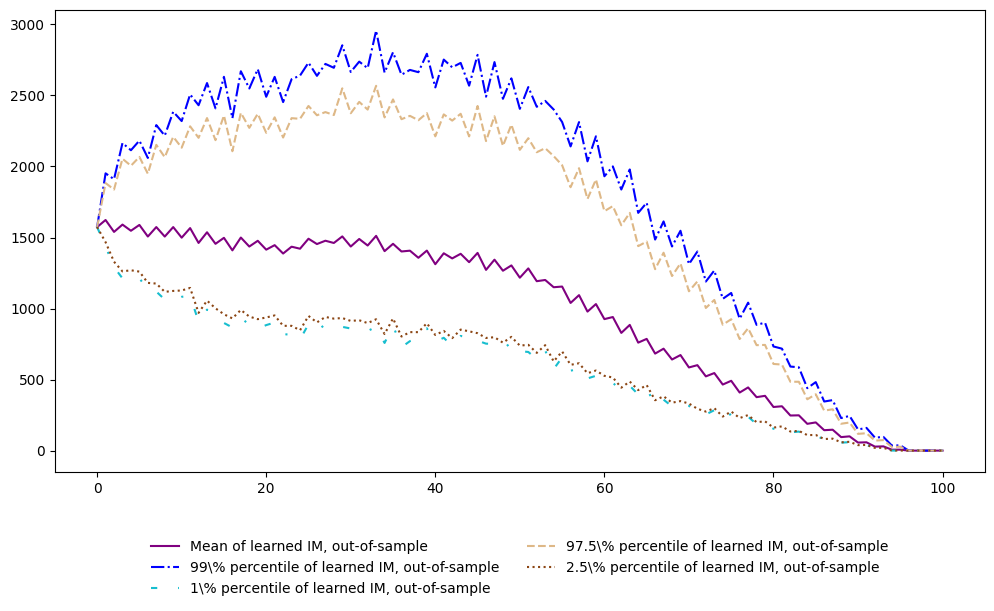

In [19]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats['mean'], label='Mean of learned IM, out-of-sample', color='purple')
plt.plot(predicted_im_stats['quantile', 0.99], label=r'99\% percentile of learned IM, out-of-sample', color='blue', linestyle='dashdot')
plt.plot(predicted_im_stats['quantile', 0.01], label=r'1\% percentile of learned IM, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
plt.plot(predicted_im_stats['quantile', 0.975], label=r'97.5\% percentile of learned IM, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats['quantile', 0.025], label=r'2.5\% percentile of learned IM, out-of-sample', color='saddlebrown', linestyle='dotted')

# uncomment the following lines if you're including the Nested MC estimator in the plot
# plt.plot(nested_timesteps, nested_im_stats['mean'], marker='s', linestyle='None', label='Mean of Nested Monte-Carlo IM, out-of-sample', color='black')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.975], marker='^', linestyle='None', label=r'97.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='orange')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.025], marker='v', linestyle='None', label=r'2.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='gray')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.99], marker='x', linestyle='None', label=r'99\% percentile of Nested Monte-Carlo IM, out-of-sample', color='red')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.01], marker='+', linestyle='None', label=r'1\% percentile of Nested Monte-Carlo IM, out-of-sample', color='green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);